In [1]:
import matplotlib.pyplot as plt

In [2]:
import torch
import numpy as np

In [3]:
def preprocess_X(X):
    # normalize features to mean 0 and variance 1 
    # return (X - X.mean(axis=0)) / np.std(X, axis=0)
    # normalize features to range [0, 1]
    return (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

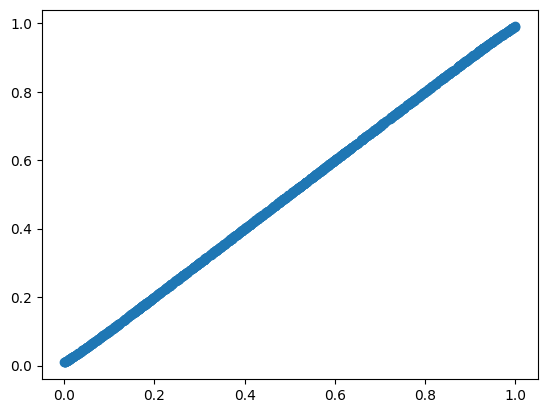

In [4]:
def generate_tuning_curves(scalars, dimensions, width):
    """
    Generate tuning curves as Gaussian curves centered around scalar values.
    
    Args:
    scalars (ndarray): Array of scalar values between 0 and 1.
    dimensions (int): Number of dimensions in the array.
    width (float): Width of the Gaussian curve.
    
    Returns:
    tuning_curves (ndarray): Array of N-dimensional arrays representing tuning curves.
    """
    positions = np.linspace(-1 * width, 1 + 1 * width, dimensions)
    tuning_curves = np.exp(-((positions[np.newaxis, :] - scalars[:, np.newaxis]) ** 2) / (2 * width ** 2))
    return tuning_curves

def estimate_scalars_from_tuning_curves(tuning_curves, width):
    """
    Estimate scalar values from arrays of N-dimensional tuning curves.
    
    Args:
    tuning_curves (ndarray): Array of N-dimensional arrays representing tuning curves.
    width (float): Width of the Gaussian curve used to generate the tuning curves.
    
    Returns:
    estimated_scalars (ndarray): Array of estimated scalar values.
    """
    dimensions = tuning_curves.shape[1]
    positions = np.linspace(-1 * width, 1 + 1 * width, dimensions)
    
    # Compute the estimated scalar values for each tuning curve
    tuning_curves = tuning_curves / tuning_curves.sum(1)[:, np.newaxis]
    estimated_scalars = np.sum(positions * tuning_curves, axis=1) / np.sum(tuning_curves, axis=1)
    return estimated_scalars


n_units_p = 10
width_of_curve = 1/n_units_p

num_samples = 1000
scalar_values = np.random.rand(num_samples)

tuning_curves = generate_tuning_curves(scalar_values, n_units_p, width_of_curve)
estimated_scalars = estimate_scalars_from_tuning_curves(tuning_curves, width_of_curve)

plt.scatter(scalar_values, estimated_scalars)

In [5]:
def get_X(
    sigma=10,
    rho=28,
    beta=8 / 3,
    duration=2000,
    dt=0.01,
    initial_state=[0, 5, 0],
    n_units_p=10
):
    # Time points
    t = np.arange(0, duration, dt)
    
    # Simulate the Lorenz system
    #X_raw = preprocess_X(np.mod(np.arange(duration), 40)[:, np.newaxis])
    X_raw = preprocess_X(
        np.mod(np.stack([
            np.arange(duration),
            np.arange(10, duration+10),
            np.arange(20, duration+20),
            np.arange(30, duration+30)
        ]).T, 40)
    )
    width_of_curve = 1/n_units_p

    X = np.array([
        generate_tuning_curves(X_raw[:, i], n_units_p, width_of_curve)
        for i in range(4)
    ])
    return X_raw, np.transpose(X, (1, 0, 2))

In [40]:
X_raw, X = get_X(duration=50000)

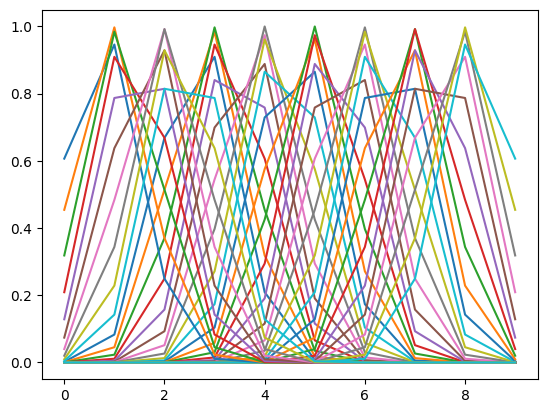

In [41]:
plt.plot(X[:40, 1].T);
#plt.plot(X.sum(0)[0] / X.sum())

In [113]:
def nonlinearity(x, scale=2, offset=0.0):
    return 1 / (1 + torch.exp(-scale * (x - offset)))

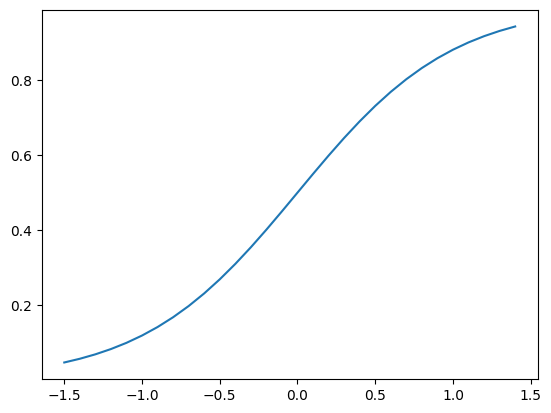

In [114]:
plt.plot(np.arange(-1.5, 1.5, 0.1), nonlinearity(torch.arange(-1.5, 1.5, 0.1)))

In [115]:
def f_homeostasis(mean_activity, threshold_offset=0.0):
    return max(mean_activity + threshold_offset, 0)

In [116]:
ALPHA = 200
DT = 1e-3
N_UNITS = 9

In [141]:
def simulate(
    X,
    lmbda1 = 1,
    lmbda2 = 50,
    lmbda3 = 0,
    lmbda4 = 0,
    n_units = N_UNITS,
    dt = DT,
    alpha = ALPHA,
    beta_in = 5e-3,
    gamma = 10,
    w=None
):
    device = torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    )  # Use GPU if available
    
    n_steps, n_features, n_units_p = X.shape

    #w = 1 * np.random.randn(n_units, n_features, n_units_p)
    #w -= w.mean()
    if w is None:
        w = np.random.uniform(0.0, 0.25, size=(n_units, n_features, n_units_p))
    
    V = torch.zeros((n_steps, n_units), device=device)
    X = torch.from_numpy(X).to(device)
    w = torch.from_numpy(w).to(device)
    a = torch.zeros(n_units, device=device)

    W = []
    W_mean_hist = []
    W_var_hist = []
    DW_max = []

    target_activity = 0.15
    # warmup
    for t in range(-200, 0):
        dv = (
            (
                -lmbda1 * V[t - 1]
                + nonlinearity(
                    torch.einsum('kij,ij->k', w, X[t])
                    - lmbda2 * f_homeostasis(V[t-1].mean(), threshold_offset=-target_activity)
                    #+ lmbda2 * f_homeostasis(-V[t-1].mean(), threshold_offset=+threshold_offset)
                )
            )
            * dt
            * alpha
        )
        
        V[t] = V[t-1] + dv
    
    for t in range(n_steps):
        dv = (
                (
                    -lmbda1 * V[t - 1]
                    + nonlinearity(
                        torch.einsum('kij,ij->k', w, X[t])
                        - lmbda2 * f_homeostasis(V[t-1].mean(), threshold_offset=-target_activity)
                        - 0 * a
                        #+ lmbda2 * f_homeostasis(-V[t-1].mean(), threshold_offset=+threshold_offset)
                    )
                )
                * dt
                * alpha
            )

        V[t] = V[t - 1] + dv
    
        dw = (
                + 30 * (target_activity - a[:, np.newaxis, np.newaxis])
                #- 0 * V[t-1, :, np.newaxis, np.newaxis]
                #- lmbda3 * w
                #- lmbda4 * a[:, np.newaxis, np.newaxis]**3
                + torch.einsum('ij,k->kij', X[t], dv/dt)
                - 1 * w * (dv/dt)[:, np.newaxis, np.newaxis]
                #+ torch.einsum('ij,k->kij', X[t], V[t])
             ) * dt * beta_in
        w += dw
        w = torch.relu(w)
        a += (V[t] - a) * dt * gamma

        # multiplicative / competetive normalization
        # w = 0.99 * w + 0.01 * (w / w.mean((1, 2))[:, np.newaxis, np.newaxis])
        
        W_mean_hist.append(w.mean().cpu().numpy())
        W_var_hist.append(w.var().cpu().numpy())
        if t % 1000 == 0:
            W.append(w.cpu().numpy())

        DW_max.append(dw.abs().max().cpu().item())
    
    return V.cpu().numpy(), w.cpu().numpy(), W_mean_hist, W_var_hist, W, a, DW_max

In [142]:
n_steps, n_features, n_units_p = X.shape
noise = np.random.uniform(0, 0.2, size=(N_UNITS, n_features, n_units_p)) + 0.2
V, w, W_mean_hist, W_var_hist, W, a, DW_max = simulate(X, w=noise)

In [143]:
V[-40:].mean(0).round(3)

array([0.255, 0.229, 0.262, 0.265, 0.189, 0.257, 0.211, 0.241, 0.168],
      dtype=float32)

In [144]:
V[-1].round(3)

array([0.065, 0.005, 0.088, 0.042, 0.401, 0.007, 0.8  , 0.515, 0.178],
      dtype=float32)

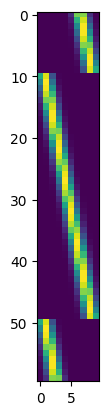

In [145]:
plt.imshow(X[-60:, 1])

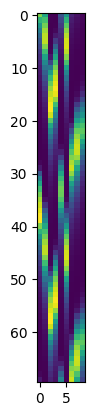

In [146]:
plt.imshow(V[-70:])

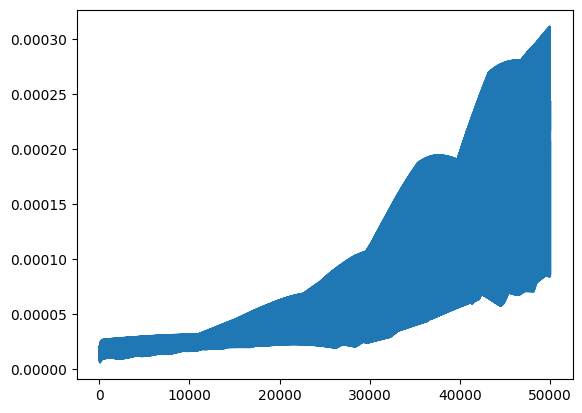

In [105]:
%matplotlib inline
plt.plot(DW_max[:])

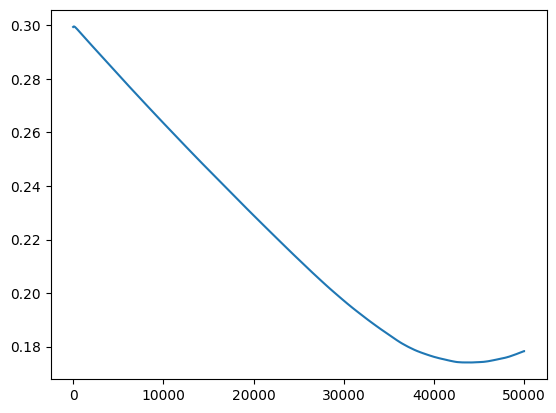

In [106]:
%matplotlib inline
plt.figure()
plt.plot(W_mean_hist)

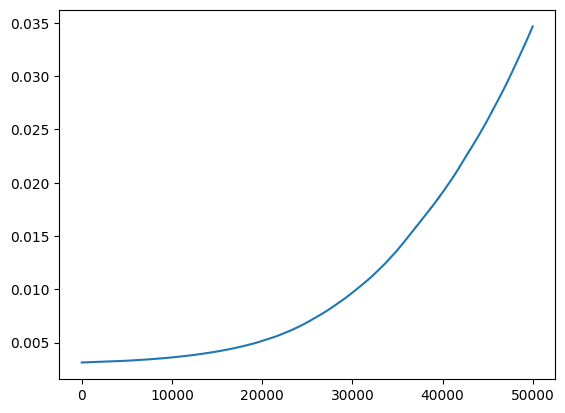

In [107]:
%matplotlib inline
plt.plot(W_var_hist)

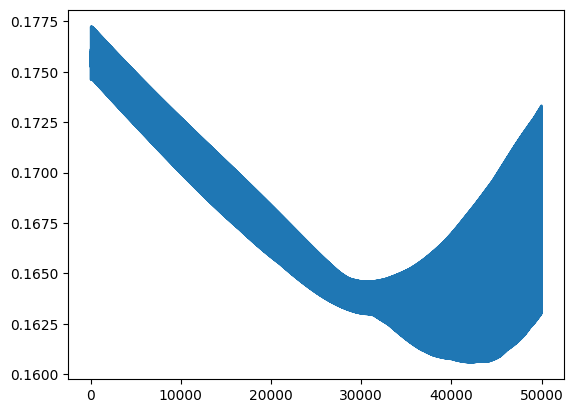

In [108]:
%matplotlib inline
plt.plot(V.mean(1)[:])

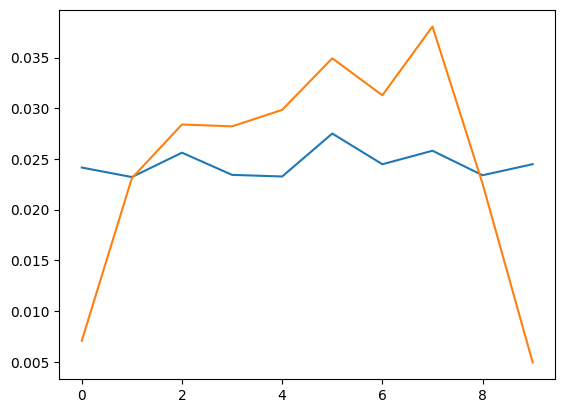

In [147]:
plt.plot(W[0][:, 0].sum(0) / W[0].sum())
plt.plot(W[-1][:, 0].sum(0) / W[-1].sum())

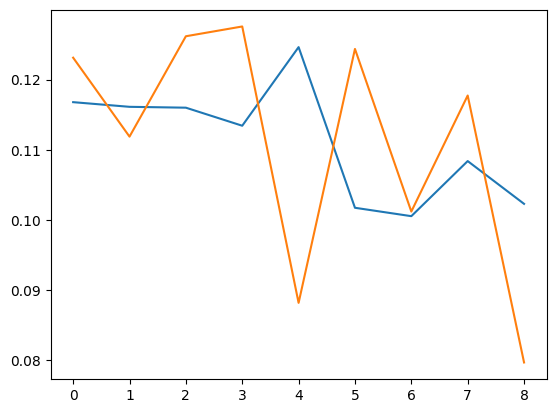

In [148]:
plt.plot(V[:2000].sum(0) / V[:2000].sum())
plt.plot(V[-2000:].sum(0) / V[-2000:].sum())
#plt.plot(X.sum(0)[0] / X.sum())

(0.0, 1.0)

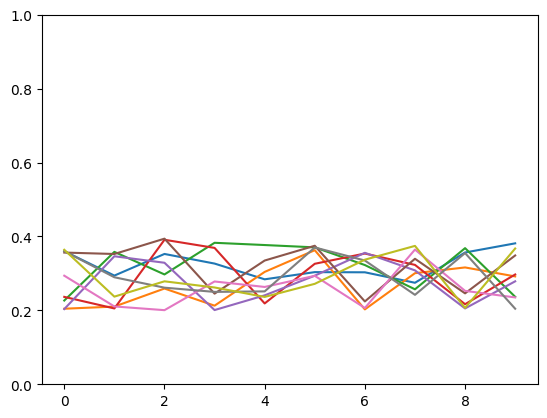

In [149]:
plt.plot(W[0][:, 0].T);
plt.ylim(0, 1)

(0.0, 1.5)

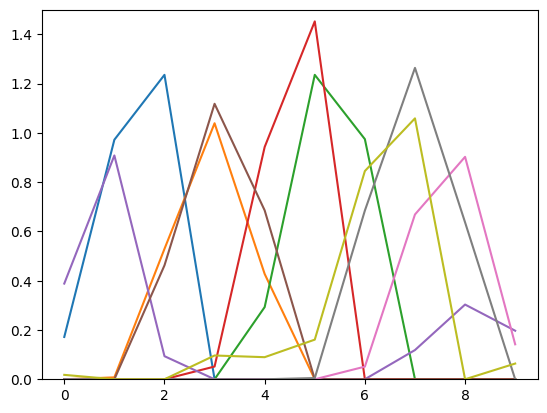

In [153]:
plt.plot(W[-1][:, 0].T);
plt.ylim(0, 1.5)

In [79]:
unit_locations0 = np.array([
    estimate_scalars_from_tuning_curves(W[0][:, i], width_of_curve)
    for i in range(1)
])

In [80]:
unit_locations = np.array([
    estimate_scalars_from_tuning_curves(w[:, i], width_of_curve)
    for i in range(1)
])

In [81]:
np.sort(unit_locations0[0].round(3))

array([0.453, 0.467, 0.473, 0.484, 0.495, 0.497, 0.499, 0.5  , 0.544])

In [82]:
np.sort(unit_locations[0].round(3))

array([0.29 , 0.408, 0.421, 0.44 , 0.444, 0.517, 0.526, 0.532, 0.587])

(array([0., 0., 0., 0., 0., 0., 2., 3., 2., 0., 0., 0., 0., 0., 0.]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        ]),
 <BarContainer object of 15 artists>)

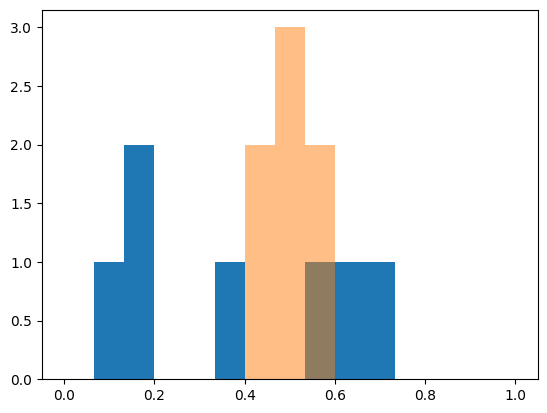

In [165]:
plt.hist(unit_locations[0], bins=15, range=(0, 1))
plt.hist(unit_locations0[0], bins=15, range=(0, 1), alpha=0.5)

In [166]:
w.sum(0)

array([[2.2876286 , 2.49626521, 1.97688119, 0.59498041, 1.56633558,
        1.40137353, 0.68760744]])

In [167]:
w.sum(2).T

array([[1.00608646, 1.86379253, 1.30481405, 1.62457249, 1.12124537,
        1.7574557 , 2.33310535]])

In [168]:
V[-1000:].sum(0)

array([547.56085, 775.49756, 661.2463 , 720.28656, 579.6086 , 571.23553,
       542.08417], dtype=float32)

In [193]:
np.einsum('kij,ij->k', w, X[0])

array([6.03599431e-04, 5.05424194e-04, 8.17290568e-02, 3.35601546e-02,
       4.24076173e-02, 1.46518796e-19, 2.26330060e-07])

In [192]:
20 * f_lateral_inhibition(V[- 1].mean())

1.5499215126037598